# Rewrite of POLE with Numpy, written by Conrad
(See e.g. "Including Systematic Uncertainties in Confidence Interval Construction for Poisson Statistics")
- Cole Kampa
- 5-5-2021

# Imports (Python)

In [1]:
import numpy as np

# Completed Functions (Python)

In [2]:
# same as before
def readin(filename='data/pole1.0.ini', verbose=True):
    # read in initialization file. remove newline character and ignore comments (line starts with "!")
    with open(filename, 'r') as f:
        lines = [i.rstrip('\n').rstrip(' ') for i in f.readlines() if not i[0] in ['!', '#', '*', 'C']]#, 'c', ]]
    # loop through lines to set proper variables
    for line in lines:
        #print(line)
        ident, val = line.split(' ')
        if ident=='of':
            filehb = val
        elif ident=='ft':
            filltrue = int(val)
        elif ident=='ff':
            fluxfactor = float(val)
        elif ident=='ll':
            conflevel = float(val)
        elif ident=='fi':
            filetrue = int(val)
        elif ident=='fn':
            filein = val
        elif ident=='fo':
            fileout = val
        elif ident=='rf':
            fmax = float(val)
        elif ident=='sw':
            width = float(val)
        elif ident=='no':
            normtrue = int(val)
        elif ident=='fc':
            FCtrue = int(val)
        elif ident=='bg':
            background = float(val)
        elif ident=='nm':
            nobs = int(val)
        elif ident=='cc':
            ctrue = int(val)
        elif ident=='bu':
            sbg = float(val)
        elif ident=='pb':
            bkpar = int(val)
        elif ident=='eu':
            sac = float(val)
        elif ident=='pu':
            spar = int(val)
        elif ident=='eb':
            bsac = float(val)
        elif ident=='pe':
            bar = int(val)
    # calculate number of steps
    step_help = fmax/width
    steps = int(step_help)
    if verbose:
        # Tell User which parameters: 
        print('Performing Conf Belt Const :')
        print(f'Output hbfile:     {filehb}')  
        print(f'fill diagnostic histos {filltrue}')
        print(f'Confidence Level {conflevel:0.5f}')
        print(f'Condition (1=yes) {normtrue}')
        print(f'stepwidth : {width:0.3f}')
        print(f'Feldman Cousins    {FCtrue}')
        print(f'fluxfactor:        {fluxfactor:0.3f}')
        print(f'Read from file: {filein}')
        print(f'Write to file: {fileout}')
        print(f'Exp. BG events     {background:0.3f}')
        print(f'Measured events    {nobs}')
        print(' ')
        print('Used Paramterisation :')
        print('Gaussian = 1')
        print('flat = 2')
        print('log-normal = 3')
        print(' ')
        print(f'rel Aeff unc (sig): {sac:0.3f}')
        print(f'Parametrization: {spar}')
        print(f'rel Aeff unc (bck): {bsac:0.3f}')
        print(f'Parametrization: {bar}')
        print(f'rel bg unc:        {sbg:0.3f}')
        print(f'Parametrization: {bkpar}')
        print(f'max flux:          {fmax:0.3f}')
        print(f'Number of steps: {steps}')
        print('CAUTION: not bigger than 1000!')
    #return lines
    return filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
           normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps

In [3]:
# same as before
def read_grid(filename='data/test.in'):
    '''
    x = background
    y = number of observed events
    '''
    x = []; y = []
    # read in input file. remove newline character
    with open(filename, 'r') as f:
        lines = [i.rstrip('\n').rstrip(' ') for i in f.readlines()]
    # loop through lines to grab x, y values set proper variables
    for line in lines:
        y_, x_ = line.split(' ')
        x.append(float(x_))
        y.append(float(y_))
    x = np.array(x)
    y = np.array(y)
    ncalc = len(x)
    return x, y, ncalc

In [380]:
# TESTING GAUSSIAN APPROX OF POISSON
def poisson_gauss_approx(mus, MUMAX=20):
    mpois = (mus <= MUMAX)
#     mgaus = ~mpois
    mupois = mus[mpois]
    mugaus = mus[~mpois]
    n0tot = []
    n0tot.append(np.random.poisson(lam=mupois))
    n0tot.append(np.random.normal(loc=mugaus, scale=mugaus**(1/2)).astype(np.int))
    return np.concatenate(n0tot)        

In [491]:
#def fluxfactors(sac,bsac,sbg,ctrue):
def fluxfactors(sac,bsac,sbg,ctrue,N_exp):
    sigfactor = np.zeros((3,N_exp)) # signal eff. unc.
    befactor = np.zeros((3,N_exp)) # bg eff. unc.
    bkfactor = np.zeros((3,N_exp)) # expected bg unc.
    # Gaussian distribution; mu=0, std=1
    a,b,r = np.random.normal(loc=0, scale=1, size=(3, N_exp))

    # Uniform distribution 
    #call ranlux(ranvec,3)
    ranvec = np.random.uniform(low=0, high=1, size=(3, N_exp))

    # Conrad
    sigfactor[0] = 1+sac*r
    sigfactor[1] = (1-sac)+2*ranvec[0]*sac
    sigfactor[2] = np.exp(sac*r - sac**2/2)

    # background efficiency factors
    if (ctrue == 1): # correlated
        befactor[0] =  1+bsac*r
        befactor[1] =  (1-bsac)+2*ranvec[0]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*r - bsac**2/2)
    else: # no correlation
        befactor[0] =  1+bsac*a
        befactor[1] =  (1-bsac)+2*ranvec[1]*bsac
        # mean of logN will be 1
        befactor[2] = np.exp(bsac*a - bsac**2/2)

    # background prediction factors.
    bkfactor[0] = (1+sbg*b)
    bkfactor[1] = (1-sbg)+2*ranvec[2]*sbg
    bkfactor[2] = np.exp(sbg*b - sbg*bsac/2) # ERROR? WHY DOES bsac (bg eff unc.) show up?
#     bkfactor[2] = np.exp(sbg*b - sbg**2/2) # CORRECTION?
    
    return sigfactor, befactor, bkfactor

def fluxlim(trisigflu, sac, sbg, k, normtrue, used, fluxfactor,
            background, nobs, bsac, width, filltrue, ctrue, spar, bar, bkpar, conflevel,
            N_exp):
    # PYTHON
    #fntot = [] # container for each experiment n_tot
    # Take flux from our MC
    bckfluxnom = background/fluxfactor
    # Perform Pseudo Experiments to calculate Integrals
    # number of experiments
    #N_exp = 100000
    #N_exp = 1000000
    #for i in range(100000): # change so this isn't hardcoded
    # TESTING WITH FEWER GENERATED EXPERIMENTS
    #for i in range(10000): # change so this isn't hardcoded
    ###sigfactor, befactor, bkfactor = fluxfactors(sac, bsac, sbg, ctrue)
    sigfactor, befactor, bkfactor = fluxfactors(sac, bsac, sbg, ctrue, N_exp)
    # uncertainty in background flux    
    bckflux = bckfluxnom*bkfactor[bkpar-1] # check bkpar indexing
    # Diagnostics histograms
    if (filltrue == 1): 
        #call hfill(k+2000,bkfactor(bkpar),1.,1.)
        # FIXME!
        pass
    # include flux uncertainty
    musignal = trisigflu*fluxfactor*sigfactor[spar-1] # check indexing
    mubck  = bckflux*befactor[bar-1] # check indexing
    # Truncation for Gaussian uncertainty
    mask_trunc = (musignal < 0.) | (mubck < 0.)
    musignal[mask_trunc] = 0.
    mubck[mask_trunc] = 0.
    ## FIX ME!!
    #mask = (musignal < 0.) | (mubck < 0.)
    #if (musignal < 0.) or (mubck < 0.):
    #    continue # want next iteration
    # generate signal and background
    ## TESTING GAUSSIAN APPROX
    nsig = poisson_gauss_approx(mus=musignal)
    nbck = poisson_gauss_approx(mus=mubck)
    # ORIGINAL
#     nsig = np.random.poisson(lam=musignal, size=N_exp)
#     nbck = np.random.poisson(lam=mubck, size=N_exp)
    #if (normtrue==0): # without normalization
    n_tot = nsig+nbck # total number observed
    # fntot.append(float(n_tot))
    fntot = n_tot.astype(np.float)
    # Diagnostics
    if (filltrue==1):
        # call hfill(k+100,fntot(nc),1.,1.)
        pass
#     else: # with normalization
#         # only keep event if nobs > nbck
#         # should verify this enforces behavior given by cond
#         if (nbck < nobs):  # < or <= ?
#             n_tot = nsig+nbck
#             fntot.append(float(n_tot))
#             if (filltrue==1):
#                 #call hfill(k+100,fntot(i),1.,1.)
#                 pass
#         else:
#             continue

    #fntot = np.array(fntot) # convert to array
    # truncate
    #mask_trunc = (musignal < 0.) | (mubck < 0.)
    fntot = fntot[~mask_trunc]
    # normalization
    if normtrue != 0:
        mask_norm = (nbck < nobs)
        fntot = fntot[~mask_norm]
    # normalizations, FC
    # sort in ascending order
    fntot = np.sort(fntot)
    # limiting index for Neyman UL
    jlim = round((1.-conflevel)*len(fntot)) - 1 # integer. if you use int() it rounds down!
    intjlim = jlim # unnecessary--using round
    nlim= fntot[intjlim]

    # make histogram "N Hist" (new for python version)
    dist, _ = np.histogram(fntot, bins=np.arange(0,101,1)) # maybe 0, 102 so 100 is in different bin than 99
    #dist, _ = np.histogram(fntot, bins=np.arange(0,102,1)) # maybe 0, 102 so 100 is in different bin than 99
    noent = np.sum(dist) # number of entries in histogram

    # FIXME
    # needed for FC?
    #####call hfill(40,nlim,trisigflu,1.)

    # default value for checking later
    resflux = -1000 # can never be encountered for counting experiment
    # calculate Neyman upper limit for the passed in n0
    if (nlim == nobs+1):
        if (used == 0):
            resflux = trisigflu-width
            print(f'\nNeyman Upper Limit: {resflux}')
            #print *,' '
            #print 300,'Neyman Upper limit:',resflux
        used = 1

    return dist, noent, used, resflux, nlim
    # can derive noent from dist, but leaving for now

In [492]:
# PYTHON
#def FC(matrix,fluxarray,nobs,nent,steps,filltrue, Philow,Phihigh,conflevel):
def FC(matrix,fluxarray,nobs,nent,steps,filltrue, conflevel):

      

#      real*4 matrix(1000,100),R(1000,100),fj
#      real*4 fluxarray(1000),temp,hbflux,nlim1,nlim2,dum
#      real*4 mtemp(1000),Rtemp(100),adder,Philow,Phihigh,P_best(100)
#      integer index(100),n_limit(2,1000),nobs,nent(1000),steps,filltrue
#      real*4 conflevel

    P_best = np.zeros(100)
    R = np.zeros((steps, 100))
    n_limit = np.zeros((2, steps))
    
    Philow=0
    Phihigh=0

    # for each n find mu_best                                           
    for j in range(100):
        #for i in range(steps):
        #    mtemp[i] = matrix[i, j]
        mtemp = matrix[:,j] # cleaner
        mtemp = np.sort(mtemp) # sort in ascending order
        # CHECK IF TRUE
        P_best[j] = mtemp[-1] # best is mtemp with highest
        if (filltrue == 1):
            # FIXME! diagnostics
            #call hfill(31,P_best(j),fluxarray(i),1.)
            pass

    # for each flux calculate likelihood ratio for each n                
    for i in range(steps):
        for j in range(100):
            if (P_best[j] != 0) and (matrix[i,j] != 0):
                R[i,j] = matrix[i,j] / P_best[j]
            else:
                R[i,j] = 0

        # find i with highest R
        Rtemp = R[i,:] # cleaner

        '''
        Rtemp = np.zeros(100)
        for j in range(100):
            Rtemp[j] = R[i,j]
            fj = float(j)
            # Diagnostics
            if (filltrue == 1):
                # FIXME!
                # call hfill(i+1100,fj,Rtemp(j),1.)
                pass
        '''
        index = np.argsort(Rtemp)[::-1]

    # call sortzv(Rtemp,index,100,1,1,0,1)
    # sort Rtemp; index is output index array (should be integer array length 100)
    # 100 "words" to sort; 1--mode=real; 1--sort in descending order; 0--sort N values;
    # 1--extra?;
    # SEEMS TO HAVE ONE TOO MANY ARGUMENTS


        # add P(for that i)
        # until sum(P) = conflevel*100 %
        #j = 0
        adder = 0. # real
        dum = conflevel*nent[i] # real
        for j_ in range(100):
            j=j_ # CHECK
            if (adder >= dum):
                break
            adder += matrix[i, index[j_]]

        index_sorted = np.sort(index[:j]) # ascending sort
        n_limit[0,i] = index_sorted[0] # CHECK
        n_limit[1,i] = index_sorted[-1] + 1 # CHECK

        # find flux which has nobs as upper limit (Philow)
        # find flux which has nobs as lower limit (Phihigh) (shift due to indexing)             
        if (n_limit[0,i] == nobs):
            Phihigh = fluxarray[i]
        if (n_limit[1,i] == nobs):
            Philow = fluxarray[i] # I think this would give wrong result...not positive

        # just to be able to have a look at the construction 
        nlim1 = float(n_limit[0,i])
        nlim2 = float(n_limit[1,i])
        hbflux = fluxarray[i]
        # FIXME! Filling histogram ID=50
        #call hfill(50,nlim1,hbflux,1.)
        #call hfill(50,nlim2,hbflux,1.)
      
    print('\nexiting flux loop')
    print(f' FC upper limit: {Phihigh:0.5f}')
    print(f' FC lower limit: {Philow:0.5f}\n\n')

    return Philow, Phihigh, n_limit

# Main Function (Python)

In [473]:
def main(ini_file='data/pole1.0.ini', N_exp=100000, sbg_override=None, sac_override=None):
    # read in steering file and print program configuration
    filehb, filltrue, fluxfactor, conflevel, filetrue, filein, fileout, fmax, width,\
        normtrue, FCtrue, background, nobs, ctrue, sbg, bkpar, sac, spar, bsac, bar, steps\
        = readin(filename=ini_file)
    if filetrue:
        x, y, ncalc = read_grid(filename='data/'+filein)
        print('-\n-\nMode: Read input from file\n-')
    else:
        x = np.array([background]) # check
        y = np.array([nobs]) # check
        ncalc = 1
        print('-\n-\nMode: single construction\n-')
    
    print(f'expected background (x): {x}')
    print(f'number of observed (y): {y}')
    
    # OVERRIDE SBG (uncertainty on bg)
    if not sbg_override is None:
        sbg = sbg_override
    # OVERRIDE SAC (uncertainty on sig. eff.)
    if not sac_override is None:
        sac = sac_overrride
    
    #### GOOD TO THIS POINT
    # open output file
    fout = open(fileout, "w")
    # Loop over input nobs/BG pairs
    for p in range(ncalc):
        fluxarray = np.zeros(steps)
        matrix = np.zeros((steps, 100))
        nent = np.zeros(steps)
        Philow=0.
        Phihigh=0.
        # FIXME! Reset histogram IDs: 50, 40, 100
        nobs_ = y[p]
        background_ = x[p]
        #print(f'-\nPerforming Construction for n0/bg: {nobs_}/{background_}\n-\n-\nRanLux Messages\n-\n')
        # message without "RanLux" Statement
        print(f'-\nPerforming Construction for n0/bg: {nobs_}/{background_}\n-\n-\n')
        trisigflux= 0.0
        # Scan through flux space and perform Construction
        used = 0
        # FIXME! Reset histogram ID: 20
        # Loop through trisigflux to try
        mus = [] # TEST
        for i in range(steps):
            mus.append(trisigflux) # TEST
            # progress tracker
            # FIXME! Update to tqdm progress bar
            if (i % int(steps/20)) == 0:
                print('.')
            
            # INCREMENTS TWICE EACH LOOP--BAD!!!
            #trisigflux =trisigflux+width # this starts us above 0?
            #fluxarray[i] = trisigflux
            
            # Diagnostics histogramms
            if (filltrue == 1):
                # FIXME! diagnostics
                #nh = 100 + i
                #call hbook1(nh,'N Dist',100,0.,100.,0.)
                pass
            
            # call fluxlim
            dist, noent, used, resflux, nlim = fluxlim(trisigflux, sac, sbg, i, normtrue, used,
                                                       fluxfactor, background_, nobs_, bsac, width,
                                                       filltrue, ctrue, spar, bar, bkpar, conflevel,
                                                       N_exp)
            # fill matrix for Feldman Cousins
            #for l in range(100):
            #    matrix[i,l] = dist[l]
            matrix[i, :] = dist # cleaner
            nent[i] = noent
            # Diagnostics histogramms
            if (filltrue == 1):
                # FIXME! diagnostics
                # nh = 1100 + i
                #call hbook2(nh,'Rank Dist.',100,0.,50.,10,0.,1.,1.)
                pass
            fluxarray[i] = trisigflux
            trisigflux += width
        
        mus = np.array(mus) # TEST
        
        # Perform Likelihood Ratio construction 
        if (FCtrue == 1):
            Philow, Phihigh, n_limit = FC(matrix,fluxarray,nobs_,nent,steps,filltrue, conflevel)

        # Write output to file !
        fout.write(f'{nobs_}, {background_}, {Philow}, {Phihigh}\n')
    # outside nobs/background loop
    fout.close()
    
    print('Calculation complete!')
    
    return mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps

# Testing Numerical Integration

In [632]:
import scipy.integrate as integrate
from scipy.stats import norm, poisson
%matplotlib inline
config_plots()

In [591]:
norm.pdf(x=0, loc=0, scale=10)

0.03989422804014327

In [674]:
def q_n_integrand(bprime, n, s, b, sigma_b):
    return poisson.pmf(k=n, mu=s+bprime) * norm.pdf(x=bprime, loc=b, scale=sigma_b)

def q_n_integrand_sigeff(seffp, n, s, b, sigma_seff):
    return poisson.pmf(k=n, mu=seffp*s+b) * norm.pdf(x=seffp, loc=1, scale=sigma_seff)

In [675]:
q_n_integrand(4, 7, 3, 4, 1)

0.05944350870943254

In [615]:
%timeit integrate.quad(q_n_integrand, 0, 60, args=(7, 3, 4, 1))

28.6 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [616]:
%timeit integrate.quad(q_n_integrand, 0, np.inf, args=(7, 3, 4, 1))

27.3 ms ± 952 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [619]:
27.3e-3 * 10000

273.0

In [620]:
%timeit integrate.quad(q_n_integrand, 0, 60, args=(7, 3, 4, 1), epsabs=1e-4, epsrel=1e-2)

21 ms ± 931 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [621]:
%timeit integrate.quad(q_n_integrand, 0, np.inf, args=(7, 3, 4, 1), epsabs=1e-4, epsrel=1e-2)

14.4 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [623]:
14.4e-3*100000 / 60

24.0

In [670]:
_ = integrate.quad(q_n_integrand, 0, np.inf, args=(20, 2, 3, 2),)# epsabs=1e-4, epsrel=1e-2)
res0, err0 = _
res0, err0

(6.352881112196441e-05, 1.1425941303390668e-08)

In [660]:
%%timeit
s = 2
b = 3
sigma_b = 2
n = 10
bs = np.linspace(0, 20, 201)
ys = poisson.pmf(k=n, mu=s+bs)
ys2 = norm.pdf(x=bs, loc=b, scale=sigma_b)
res = np.trapz(ys*ys2, x=bs)

180 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [671]:
s = 2
b = 3
sigma_b = 2
n = 20 # 100 # 10
bs = np.linspace(0, 150, 1501)
ys = poisson.pmf(k=n, mu=s+bs)
ys2 = norm.pdf(x=bs, loc=b, scale=sigma_b)
res = np.trapz(ys*ys2, x=bs)
res

6.352881112199478e-05

In [672]:
(res-res0)

3.037121335675019e-17

In [673]:
(res-res0)/res0

4.780699153718251e-13

In [661]:
100 * 50 / 0.05

100000.0

In [662]:
50/.05

1000.0

In [663]:
180e-6 * 100000

18.0

In [649]:
288e-6 * 100000

28.8

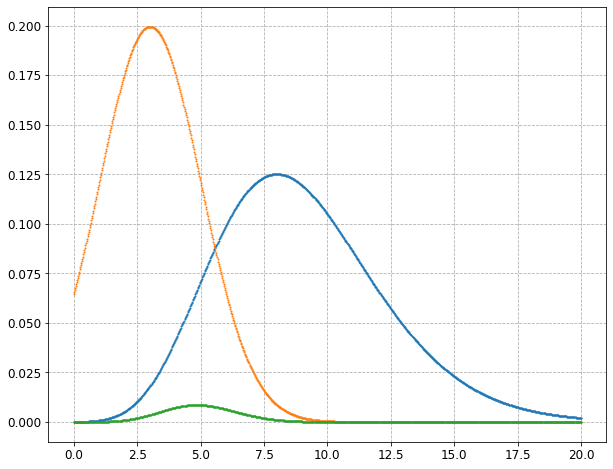

In [650]:
fig, ax = plt.subplots()
ax.scatter(bs, ys, s=1)
ax.scatter(bs, ys2, s=1)
ax.scatter(bs, ys*ys2, s=1)

In [ ]:
s = 2
b = 3
sigma_seff = 0.4
n = 10 #20 # 100 # 10
bs = np.linspace(0, 20, 201)
ys = poisson.pmf(k=n, mu=s+bs)
ys2 = norm.pdf(x=bs, loc=b, scale=sigma_b)
res = np.trapz(ys*ys2, x=bs)
res

In [ ]:
(res-res0)

(res-res0)/res0

100 * 50 / 0.05

50/.05

180e-6 * 100000

288e-6 * 100000

fig, ax = plt.subplots()
ax.scatter(bs, ys, s=1)
ax.scatter(bs, ys2, s=1)
ax.scatter(bs, ys*ys2, s=1)

In [593]:
1/((2*np.pi)**(1/2)*10)

0.039894228040143274

In [681]:
1-norm.cdf(0, loc=3, scale=2)

0.9331927987311419

In [680]:
norm.cdf(150, loc=3, scale=2)-norm.cdf(0, loc=3, scale=2)

0.9331927987311419

In [757]:
norm.pdf(3, loc=1, scale=0.4)

3.7167987868357447e-06

In [755]:
norm.pdf(b+5*sigma_b, loc=b, scale=sigma_b)

2.4778658578904965e-07

In [756]:
b+5*sigma_b

45

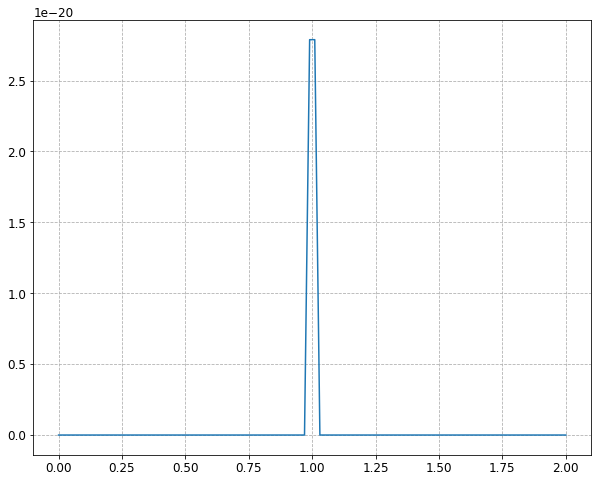

In [801]:
seffs = np.linspace(0, 2, 100)
ys = norm.pdf(seffs, loc=1, scale=1e-3)
fig, ax = plt.subplots()
ax.plot(seffs, ys)

In [961]:
#%%timeit
s = 20 # 5
b = 15
sigma_b = 6 # 10
norm_factor_b = 1/(1-norm.cdf(0, loc=b, scale=sigma_b))
# n = 20 # 100 # 10
ns = np.arange(0, 101)
# bs = np.linspace(0, 150, 15001)
# bs = np.linspace(0, 100, 1001)
bs = np.linspace(0, b + 5*sigma_b, 500)
# seffs = np.array([1-1e-5, 1-1e-9, 1, 1+1e-9, 1+1e-5]) # TEST WITH NO UNCERTAINTY
seffs = np.linspace(0, 3, 500)
# seffs = np.linspace(0, 4, 401)
sigma_seff = 1e-9 # TEST WITH NO UNCERTAINTY
sigma_seff = 0.4
norm_factor_seff = 1/(1-norm.cdf(0, loc=1, scale=sigma_seff))
# if sigma_seff > 0:
#     norm_factor_seff = 1/(1-norm.cdf(0, loc=1, scale=sigma_seff))
# else:
#     norm_factor_seff = 1
results_b = []
results_seff = []
results_both = []

for n in ns:
    # bg
    ys = poisson.pmf(k=n, mu=s+bs)
    ys2 = norm.pdf(x=bs, loc=b, scale=sigma_b)
    res_b = norm_factor_b*np.trapz(ys*ys2, x=bs)
    results_b.append(res_b)
    # seff
    ys = poisson.pmf(k=n, mu=seffs*s + b)
    ys2 = norm.pdf(x=seffs, loc=1, scale=sigma_seff)
    res_seff = norm_factor_seff*np.trapz(ys*ys2, x=seffs)
    results_seff.append(res_seff)
    # both
    SE, BS = np.meshgrid(seffs, bs)
    ys = poisson.pmf(k=n, mu=SE*s + BS)
    ys2 = norm.pdf(x=BS, loc=b, scale=sigma_b)
    ys3 = norm.pdf(x=SE, loc=1, scale=sigma_seff)
    res_both = norm_factor_b * norm_factor_seff * np.trapz(np.trapz(ys*ys2*ys3, x=seffs, axis=-1), x=bs, axis=-1)
    results_both.append(res_both)

# results_b = np.array(results_b)
results_seff = np.array(results_seff)
# results_both = np.array(results_both)

In [962]:
norm_factor, 1/norm_factor, (1 - 1/norm_factor)

(1.071589923711044, 0.9331927987311419, 0.06680720126885809)

In [963]:
results_b.sum(), results_seff.sum(), results_both.sum()

AttributeError: 'list' object has no attribute 'sum'

In [ ]:
np.trapz([0,  1], x=[1, 1], axis=-1)

In [ ]:
norm_factor_seff

In [964]:
21.1e-3 * 1000

21.1

In [965]:
pdf_base = poisson.pmf(k=ns, mu=s+b)

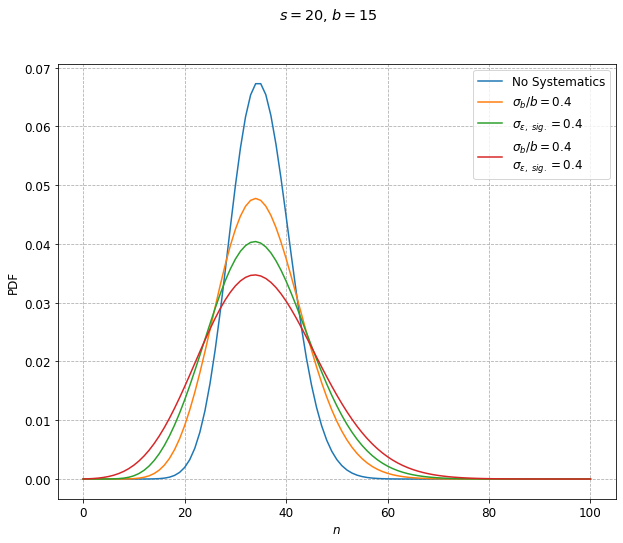

In [966]:
fig, ax = plt.subplots()
ax.plot(ns, pdf_base, label='No Systematics')
ax.plot(ns, results_b, label=r'$\sigma_b/b = 0.4$')
ax.plot(ns, results_seff, label=r'$\sigma_{\epsilon,\ sig.} = 0.4$')
ax.plot(ns, results_both, label=r'$\sigma_b/b = 0.4$'+'\n'+r'$\sigma_{\epsilon,\ sig.} = 0.4$')
ax.set_xlabel(r'$n$')
ax.set_ylabel('PDF')
fig.suptitle(rf'$s = {s}$, $b = {b}$')
ax.legend();

In [802]:
### FULL MATRIX

In [803]:
np.linspace(0, 50, 1001)

array([ 0.  ,  0.05,  0.1 , ..., 49.9 , 49.95, 50.  ])

In [804]:
np.arange(0, 101)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100])

In [809]:
np.zeros((len(ss), len(ns))).shape

(1001, 101)

In [825]:
norm.cdf(0, loc=1, scale=sigma_seff), norm.sf(2, loc=1, scale=sigma_seff)

(0.006209665325776132, 0.006209665325776132)

In [908]:
#%%timeit
ss = np.linspace(0, 50, 5001)# 20 # 5
# ss = np.linspace(0, 50, 1001)# 20 # 5
#ss = np.linspace(0, 100, 1001)# 20 # 5
# ss = np.linspace(0, 50, 501)
# ss = np.linspace(0, 50, 101)
b = 2 # 15
# sigma_b = 6 # 10
# norm_factor_b = 1/(1-norm.cdf(0, loc=b, scale=sigma_b))
# n = 20 # 100 # 10
#ns = np.arange(0, 101)
ns = np.arange(0, 100)
# bs = np.linspace(0, 150, 15001)
# bs = np.linspace(0, 100, 1001)
# bs = np.linspace(0, b + 5*sigma_b, 500)
# seffs = np.array([1-1e-5, 1-1e-9, 1, 1+1e-9, 1+1e-5]) # TEST WITH NO UNCERTAINTY
# seffs = np.linspace(0, 3, 500)
# seffs = np.linspace(0, 3, 301)
seffs = np.linspace(0, 2, 401)
smax = np.max(seffs)
# seffs = np.linspace(0, 4, 401)
# sigma_seff = 1e-9 # TEST WITH NO UNCERTAINTY
sigma_seff = 0.4
norm_factor_seff = 1/(1-norm.cdf(0, loc=1, scale=sigma_seff)-norm.sf(smax, loc=1, scale=sigma_seff))
# if sigma_seff > 0:
#     norm_factor_seff = 1/(1-norm.cdf(0, loc=1, scale=sigma_seff))
# else:
#     norm_factor_seff = 1
# results_b = []
# results_seff = []
# results_both = []

matrix_seff = np.zeros((len(ss), len(ns)))
matrix_0 = np.zeros((len(ss), len(ns)))

for i, s in enumerate(ss):
    # calculate without systematics
    matrix_0[i, :] = poisson.pmf(k=ns, mu=s+b)
    results_seff = []
    for j, n in enumerate(ns):
        # bg
    #     ys = poisson.pmf(k=n, mu=s+bs)
    #     ys2 = norm.pdf(x=bs, loc=b, scale=sigma_b)
    #     res_b = norm_factor_b*np.trapz(ys*ys2, x=bs)
    #     results_b.append(res_b)
        # seff
        ys = poisson.pmf(k=n, mu=seffs*s + b)
        ys2 = norm.pdf(x=seffs, loc=1, scale=sigma_seff)
        res_seff = norm_factor_seff*np.trapz(ys*ys2, x=seffs)
        results_seff.append(res_seff)
        # both
    #     SE, BS = np.meshgrid(seffs, bs)
    #     ys = poisson.pmf(k=n, mu=SE*s + BS)
    #     ys2 = norm.pdf(x=BS, loc=b, scale=sigma_b)
    #     ys3 = norm.pdf(x=SE, loc=1, scale=sigma_seff)
    #     res_both = norm_factor_b * norm_factor_seff * np.trapz(np.trapz(ys*ys2*ys3, x=seffs, axis=-1), x=bs, axis=-1)
    #     results_both.append(res_both)

    # results_b = np.array(results_b)
    results_seff = np.array(results_seff)
    # results_both = np.array(results_both)
    # save to matrix
    matrix_seff[i, :] = results_seff

In [909]:
poisson.sf(k=99, mu=50+b+0.4*50)

0.0010335547341868664

In [897]:
np.sum(matrix_0, axis=1)

array([1.        , 1.        , 1.        , ..., 0.41596659, 0.41211851,
       0.40828137])

In [932]:
matrix_0.shape

(5001, 100)

In [933]:
ss.shape

(5001,)

In [845]:
np.sum(matrix_seff, axis=1)

array([0.99999884, 0.99999884, 0.99999884, ..., 0.99084605, 0.9907208 ,
       0.99059437])

In [910]:
Pl_0, Ph_0, nl_0 = FC(matrix=matrix_0,fluxarray=ss,nobs=0,nent=np.ones_like(ss),steps=len(ss),
                      filltrue=False, conflevel=0.9)


exiting flux loop
 FC upper limit: 1.08000
 FC lower limit: 0.00000




In [911]:
Pl_seff, Ph_seff, nl_seff = FC(matrix=matrix_seff,fluxarray=ss,nobs=0,nent=np.ones_like(ss),steps=len(ss),
                               filltrue=False, conflevel=0.9)


exiting flux loop
 FC upper limit: 1.35000
 FC lower limit: 0.00000




In [913]:
#ULs
np.array([ss[(nl_0[0] == i)][-1] for i in np.arange(0, 21)])

array([ 1.08,  2.52,  3.91,  5.42,  6.59,  7.98,  9.46, 10.53, 11.99,
       13.29, 14.5 , 15.81, 17.  , 18.05, 19.5 , 20.52, 21.99, 23.01,
       24.15, 25.5 , 26.52])

In [940]:
matrix1 = matrix_0
matrix2 = matrix_seff
P_best1 = np.zeros(100)
P_best2 = np.zeros(100)
ss_best1 = np.zeros(100)
ss_best2 = np.zeros(100)

# for each n find mu_best                                           
for j in range(100):
    # 1
    mtemp1 = matrix1[:,j] # cleaner
    argtemp1 = np.argsort(mtemp1)[-1]
    mtemp1 = np.sort(mtemp1) # sort in ascending order
    P_best1[j] = mtemp1[-1] # best is mtemp with highest
    ss_best1[j] = ss[argtemp1]
    # 2
    mtemp2 = matrix2[:,j] # cleaner
    argtemp2 = np.argsort(mtemp2)[-1]
    mtemp2 = np.sort(mtemp2) # sort in ascending order
    P_best2[j] = mtemp2[-1] # best is mtemp with highest
    ss_best2[j] = ss[argtemp2]

In [942]:
ss_best1

array([ 0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.,
       37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
       50., 50., 50., 50., 50., 50., 50., 50., 50.])

In [943]:
ss_best2

array([ 0.  ,  0.  ,  0.  ,  0.9 ,  1.83,  2.76,  3.69,  4.62,  5.53,
        6.45,  7.35,  8.26,  9.16, 10.05, 10.95, 11.84, 12.73, 13.62,
       14.51, 15.4 , 16.29, 17.18, 18.06, 18.95, 19.83, 20.72, 21.6 ,
       22.48, 23.37, 24.25, 25.13, 26.01, 26.9 , 27.78, 28.66, 29.54,
       30.42, 31.3 , 32.18, 33.06, 33.94, 34.83, 35.71, 36.59, 37.47,
       38.35, 39.22, 40.1 , 40.98, 41.86, 42.74, 43.62, 44.5 , 45.38,
       46.26, 47.14, 48.02, 48.9 , 49.77, 50.  , 50.  , 50.  , 50.  ,
       50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  ,
       50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  ,
       50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  ,
       50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  , 50.  ,
       50.  ])

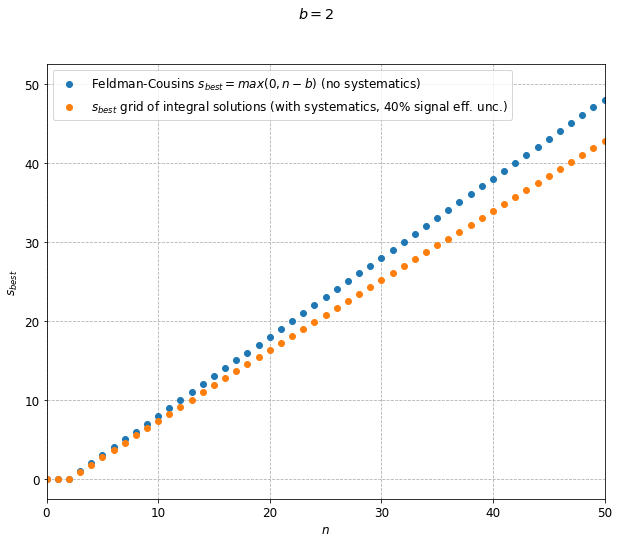

In [955]:
fig, ax = plt.subplots()

ax.scatter(ns, ss_best1, label=r'Feldman-Cousins $s_{best} = max(0, n-b)$ (no systematics)')
ax.scatter(ns, ss_best2, label=r'$s_{best}$ grid of integral solutions (with systematics, 40% signal eff. unc.)')

ax.set_xlim([0, 50])

ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$s_{best}$')
fig.suptitle(rf'$b = {b}$')
ax.legend();
fig.savefig('s_best_fig2.png', transparent=False)
fig.savefig('s_best_fig2.pdf', transparent=False)

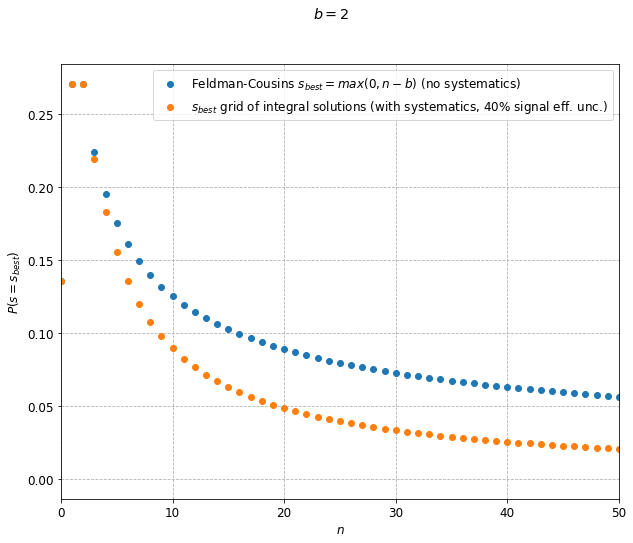

In [954]:
fig, ax = plt.subplots()

ax.scatter(ns, P_best1, label=r'Feldman-Cousins $s_{best} = max(0, n-b)$ (no systematics)')
ax.scatter(ns, P_best2, label=r'$s_{best}$ grid of integral solutions (with systematics, 40% signal eff. unc.)')

ax.set_xlim([0, 50])

ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$P(s=s_{best})$')
fig.suptitle(rf'$b = {b}$')
ax.legend();
fig.savefig('P_s_best_fig2.png', transparent=False)
fig.savefig('P_s_best_fig2.pdf', transparent=False)

In [916]:
fc_best = np.array([max(0, n_-b) for n_ in ns])

In [917]:
fc_best

array([ 0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])

In [918]:
ss_best - fc_best

array([  0.  ,   0.  ,   0.  ,  -0.1 ,  -0.17,  -0.24,  -0.31,  -0.38,
        -0.47,  -0.55,  -0.65,  -0.74,  -0.84,  -0.95,  -1.05,  -1.16,
        -1.27,  -1.38,  -1.49,  -1.6 ,  -1.71,  -1.82,  -1.94,  -2.05,
        -2.17,  -2.28,  -2.4 ,  -2.52,  -2.63,  -2.75,  -2.87,  -2.99,
        -3.1 ,  -3.22,  -3.34,  -3.46,  -3.58,  -3.7 ,  -3.82,  -3.94,
        -4.06,  -4.17,  -4.29,  -4.41,  -4.53,  -4.65,  -4.78,  -4.9 ,
        -5.02,  -5.14,  -5.26,  -5.38,  -5.5 ,  -5.62,  -5.74,  -5.86,
        -5.98,  -6.1 ,  -6.23,  -7.  ,  -8.  ,  -9.  , -10.  , -11.  ,
       -12.  , -13.  , -14.  , -15.  , -16.  , -17.  , -18.  , -19.  ,
       -20.  , -21.  , -22.  , -23.  , -24.  , -25.  , -26.  , -27.  ,
       -28.  , -29.  , -30.  , -31.  , -32.  , -33.  , -34.  , -35.  ,
       -36.  , -37.  , -38.  , -39.  , -40.  , -41.  , -42.  , -43.  ,
       -44.  , -45.  , -46.  , -47.  ])

In [851]:
P_best

array([1.35335283e-01, 2.70670566e-01, 2.70670566e-01, 2.24041808e-01,
       1.95366815e-01, 1.75467370e-01, 1.60623141e-01, 1.49002780e-01,
       1.39586532e-01, 1.31755640e-01, 1.25110036e-01, 1.19378060e-01,
       1.14367916e-01, 1.09939814e-01, 1.05989148e-01, 1.02435867e-01,
       9.92175316e-02, 9.62846278e-02, 9.35973165e-02, 9.11231325e-02,
       8.88353174e-02, 8.67115916e-02, 8.47332343e-02, 8.28843844e-02,
       8.11515025e-02, 7.95229515e-02, 7.79886659e-02, 7.65398893e-02,
       7.51689635e-02, 7.38691571e-02, 7.26345265e-02, 7.14598008e-02,
       7.03402874e-02, 6.92717926e-02, 6.82505555e-02, 6.72731924e-02,
       6.63366491e-02, 6.54381611e-02, 6.45752192e-02, 6.37455398e-02,
       6.29470394e-02, 6.21778130e-02, 6.14361146e-02, 6.07203404e-02,
       6.00290146e-02, 5.93607765e-02, 5.87143689e-02, 5.80886285e-02,
       5.74824770e-02, 5.68949133e-02, 5.63250063e-02, 5.57718891e-02,
       5.52347532e-02, 5.41925880e-02, 5.21854552e-02, 4.93389758e-02,
      

In [919]:
#ULs
np.array([ss[(nl_0[0] == i)][-1] for i in np.arange(0, 21)])

array([ 1.08,  2.52,  3.91,  5.42,  6.59,  7.98,  9.46, 10.53, 11.99,
       13.29, 14.5 , 15.81, 17.  , 18.05, 19.5 , 20.52, 21.99, 23.01,
       24.15, 25.5 , 26.52])

In [920]:
#LLs
np.array([ss[(nl_0[1] == i)][-1] for i in np.arange(5, 21)])

array([ 0.43,  1.08,  1.58,  2.13,  2.52,  3.5 ,  3.91,  5.  ,  5.42,
        6.5 ,  7.48,  7.98,  9.03,  9.46, 10.51, 11.55])

In [ ]:
nl_0

In [837]:
Pl_0, Ph_0

(1.5, 10.5)

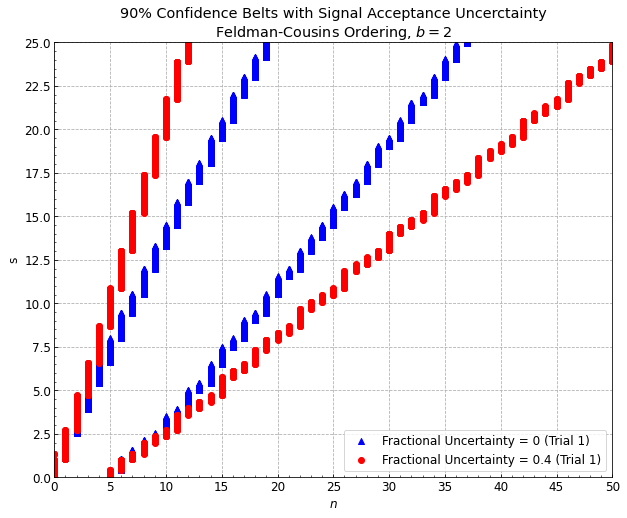

In [923]:
fig, ax = plt.subplots()

offset = 0. # 0.1
ax.scatter(nl_0[0,:]+offset, ss, c='blue', marker='^',
           label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(nl_0[1,:]+offset, ss, c='blue', marker='^')
# ax.scatter(n_limit2[0,:]+0.1, mus2, marker='^', facecolors='none', edgecolors='cyan',
#            label=r'Fractional Uncertainty = 0 (Trial 2)')
# ax.scatter(n_limit2[1,:]+0.1, mus2, marker='^', facecolors='none', edgecolors='cyan')

ax.scatter(nl_seff[0,:], ss, c='red',
           label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(nl_seff[1,:], ss, c='red')
# ax.scatter(n_limit_2[0,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange',
#            label=r'Fractional Uncertainty = 0.4 (Trial 2)')
# ax.scatter(n_limit_2[1,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,50])
ax.set_ylim([0,25])
ax.set_xticks(np.arange(0, 55, 5))
ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel('s');
ax.set_title('90% Confidence Belts with Signal Acceptance Uncerctainty\n'+r'Feldman-Cousins Ordering, $b = 2$')
ax.legend()
fig.savefig('fig2_recreate_integrate.png', transparent=False)
fig.savefig('fig2_recreate_integrate.pdf', transparent=False)

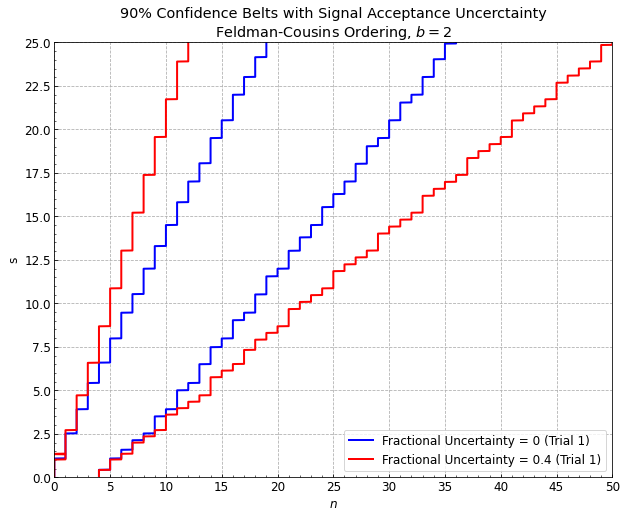

In [952]:
fig, ax = plt.subplots()

offset = 0. # 0.1
ax.plot(nl_0[0,:]+offset, ss, color='blue', linewidth=2, #marker='^',
           label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.plot(nl_0[1,:]+offset-1, ss, color='blue', linewidth=2,)# marker='^')
# ax.scatter(n_limit2[0,:]+0.1, mus2, marker='^', facecolors='none', edgecolors='cyan',
#            label=r'Fractional Uncertainty = 0 (Trial 2)')
# ax.scatter(n_limit2[1,:]+0.1, mus2, marker='^', facecolors='none', edgecolors='cyan')

ax.plot(nl_seff[0,:], ss, color='red', linewidth=2,
           label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.plot(nl_seff[1,:]-1, ss, color='red', linewidth=2,)
# ax.scatter(n_limit_2[0,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange',
#            label=r'Fractional Uncertainty = 0.4 (Trial 2)')
# ax.scatter(n_limit_2[1,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,50])
ax.set_ylim([0,25])

# ax.set_xlim([0,2])
# ax.set_ylim([0,2.5])

ax.set_xticks(np.arange(0, 55, 5))
ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel('s');
ax.set_title('90% Confidence Belts with Signal Acceptance Uncerctainty\n'+r'Feldman-Cousins Ordering, $b = 2$')
ax.legend()
fig.savefig('fig2_lines_integrate.png', transparent=False)
fig.savefig('fig2_lines_integrate.pdf', transparent=False)

# Recreate Figure 2

In [509]:
N_exp = int(1e5)

In [559]:
# no signal uncertainty
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/fig2_no_sys.ini',
                                                                     N_exp=N_exp)
mus2, Philow2, Phihigh2, n_limit2, matrix2, fluxarray2, nent2, steps2 = main(ini_file='data/fig2_no_sys.ini',
                                                                             N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.050
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     2.000
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          50.000
Number of steps: 1000
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [2.]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/2.0
-
-

.

Neyman Upper Limit: 0.25
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 1.05000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.05

In [560]:
# signal uncertainty
mus_, Philow_, Phihigh_, n_limit_, matrix_, fluxarray_, nent_, steps_ = main(ini_file='data/fig2_sys.ini',
                                                                             N_exp=N_exp)
mus_2, Philow_2, Phihigh_2, n_limit_2, matrix_2, fluxarray_2, nent_2, steps_2 = main(ini_file='data/fig2_sys.ini',
                                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.050
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     2.000
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.400
Parametrization: 1
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          50.000
Number of steps: 1000
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [2.]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/2.0
-
-

.

Neyman Upper Limit: 0.3
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 1.35000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.050

In [561]:
#mus, n_limit

In [562]:
mus.shape, n_limit.shape

((1000,), (2, 1000))

In [563]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
#%matplotlib inline
%matplotlib notebook

from plot_config import config_plots
config_plots()

In [564]:
config_plots()

In [565]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
# ax.scatter(n_limit[0,:], mus, c='blue', marker='^',
#            label=r'Fractional Uncertainty = 0 (Trial 1)')
# ax.scatter(n_limit[1,:], mus, c='blue', marker='^')
# ax.scatter(n_limit2[0,:], mus2, marker='^', facecolors='none', edgecolors='cyan',
#            label=r'Fractional Uncertainty = 0 (Trial 2)')
# ax.scatter(n_limit2[1,:], mus2, marker='^', facecolors='none', edgecolors='cyan')

ax.scatter(n_limit[0,:]+0.1, mus, c='blue', marker='^',
           label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(n_limit[1,:]+0.1, mus, c='blue', marker='^')
ax.scatter(n_limit2[0,:]+0.1, mus2, marker='^', facecolors='none', edgecolors='cyan',
           label=r'Fractional Uncertainty = 0 (Trial 2)')
ax.scatter(n_limit2[1,:]+0.1, mus2, marker='^', facecolors='none', edgecolors='cyan')

ax.scatter(n_limit_[0,:], mus_, c='red',
           label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(n_limit_[1,:], mus_, c='red')
ax.scatter(n_limit_2[0,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange',
           label=r'Fractional Uncertainty = 0.4 (Trial 2)')
ax.scatter(n_limit_2[1,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,50])
ax.set_ylim([0,25])
ax.set_xticks(np.arange(0, 55, 5))
ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel('s');
ax.set_title('90% Confidence Belts with Signal Acceptance Uncerctainty\n'+r'Feldman-Cousins Ordering, $b = 2$')
ax.legend()
fig.savefig('fig2_recreate.png', transparent=False)
fig.savefig('fig2_recreate.pdf', transparent=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


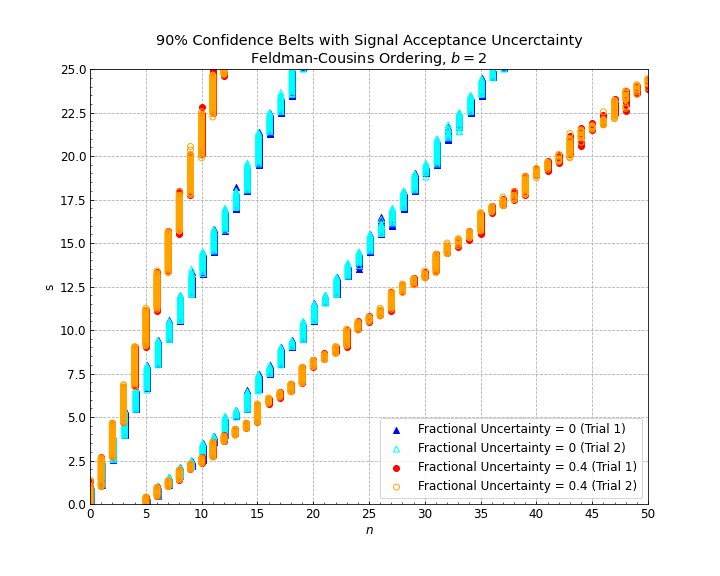

In [566]:
fig

In [567]:
#ULs
[mus[(n_limit[0] == i)][-1] for i in np.arange(2, 7)], [mus2[(n_limit2[0] == i)][-1] for i in np.arange(2, 7)]

([3.899999999999994,
  5.399999999999989,
  6.5999999999999845,
  7.99999999999998,
  9.45],
 [3.899999999999994,
  5.399999999999989,
  6.649999999999984,
  7.94999999999998,
  9.399999999999999])

In [568]:
[mus_[(n_limit_[0] == i)][-1] for i in np.arange(2, 7)], [mus_2[(n_limit_2[0] == i)][-1] for i in np.arange(2, 7)]

([4.6499999999999915,
  6.749999999999984,
  8.999999999999993,
  11.150000000000023,
  13.350000000000055],
 [4.6499999999999915,
  6.849999999999984,
  9.049999999999994,
  11.250000000000025,
  13.400000000000055])

In [571]:
#LLs
[mus[(n_limit[1] == i)][-1] for i in np.arange(5, 7)], [mus2[(n_limit2[1] == i)][-1] for i in np.arange(5, 7)]

([0.39999999999999997, 1.0500000000000003],
 [0.39999999999999997, 1.0500000000000003])

In [572]:
[mus_[(n_limit_[1] == i)][-1] for i in np.arange(5, 7)], [mus_2[(n_limit_2[1] == i)][-1] for i in np.arange(5, 7)]

([0.39999999999999997, 1.0000000000000002],
 [0.39999999999999997, 0.9500000000000003])

In [ ]:
[mus[(n_limit[1] == i+1)][-1] for i in np.arange(9,21)]

# Recreate Figure 3
- Confidence Interval width vs. background uncertainty.

In [402]:
# N_exp = int(1e5)
N_exp = int(5e5)

In [375]:
np.linspace(0, 0.4, 81)

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ])

In [409]:
_ = main(ini_file='data/fig3b.ini', N_exp=N_exp, sbg_override=0.)
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = _

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.050
Feldman Cousins    1
fluxfactor:        1.000
Read from file: fig3b.in
Write to file: test.out
Exp. BG events     6.000
Measured events    17
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 1
max flux:          50.000
Number of steps: 1000
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [6.]
number of observed (y): [17]
-
Performing Construction for n0/bg: 17/6.0
-
-

.
.
.
.
.
.
.
.

Neyman Upper Limit: 17.600000000000115
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 19.00000
 FC lower limit: 5.00000


Calculation complete!


In [410]:
[mus[(n_limit[0] == i)][-1] for i in np.arange(21)]

[0.7000000000000001,
 1.0500000000000003,
 1.5500000000000007,
 2.1000000000000005,
 2.799999999999998,
 4.049999999999994,
 5.449999999999989,
 6.549999999999985,
 7.99999999999998,
 9.249999999999996,
 10.450000000000014,
 11.800000000000033,
 12.950000000000049,
 14.100000000000065,
 15.500000000000085,
 16.5000000000001,
 17.95000000000012,
 19.000000000000135,
 20.950000000000163,
 21.950000000000177,
 23.000000000000192]

In [408]:
[mus[(n_limit[1] == i+1)][-1] for i in np.arange(9,21)]

[0.22000000000000006,
 1.0000000000000007,
 1.5600000000000012,
 2.149999999999998,
 2.8299999999999836,
 3.509999999999969,
 4.079999999999957,
 5.049999999999937,
 5.469999999999928,
 6.529999999999905,
 7.529999999999884,
 8.009999999999874]

In [405]:
[mus[(n_limit[0] == i)][-1] for i in np.arange(21)]

[0.7300000000000004,
 1.1000000000000008,
 1.5600000000000012,
 2.149999999999998,
 2.8299999999999836,
 4.079999999999957,
 5.469999999999928,
 6.549999999999905,
 8.009999999999874,
 9.479999999999842,
 10.50999999999982,
 11.92999999999979,
 13.019999999999767,
 14.089999999999744,
 15.489999999999714,
 16.50999999999978,
 17.97000000000001,
 19.030000000000175,
 20.99000000000048,
 22.040000000000646,
 23.130000000000816]

In [408]:
[mus[(n_limit[1] == i+1)][-1] for i in np.arange(9,21)]

[0.22000000000000006,
 1.0000000000000007,
 1.5600000000000012,
 2.149999999999998,
 2.8299999999999836,
 3.509999999999969,
 4.079999999999957,
 5.049999999999937,
 5.469999999999928,
 6.529999999999905,
 7.529999999999884,
 8.009999999999874]

In [393]:
mus

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 4.997e+01, 4.998e+01,
       4.999e+01])

In [376]:
def single_run(sbg, N_exp):
    _ = main(ini_file='data/fig3b.ini', N_exp=N_exp, sbg_override=sbg)
    mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = _
    return Philow, Phihigh

def single_run_all(sbg, N_exp):
    _ = main(ini_file='data/fig3b.ini', N_exp=N_exp, sbg_override=sbg)
    mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = _
    return Philow, Phihigh, 

In [377]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import multiprocessing

In [971]:
#N_exp = int(1e5)
N_exp = int(5e5)
# sbgs = np.linspace(0, 0.4, 81)
sbgs = np.linspace(0, 0.4, 41)

# testing
# N_exp = int(1e3)
# sbgs = np.linspace(0, 0.4, 9)

print('Calculating CI with varying bg uncertainty')
# get CPU information
num_cpu = multiprocessing.cpu_count()
# parallel for loop
temp = (Parallel(n_jobs=num_cpu)(delayed(single_run)(sbg, N_exp) for sbg in tqdm(sbgs, desc='sbg #')))
# split output
Philows = np.array([i[0] for i in temp])
Phihighs = np.array([i[1] for i in temp])
Delta_Phis = Phihighs - Philows

Calculating CI with varying bg uncertainty


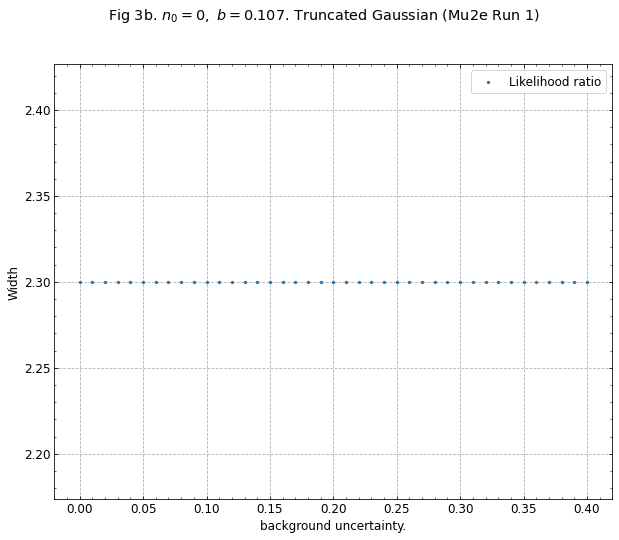

In [972]:
# GAUSSIAN APPROX, 5e5 experiments
# rf 100
# sw 0.1
fig, ax = plt.subplots()
# ax.plot(sbgs, Delta_Phis, label='Likelihood ratio')
ax.scatter(sbgs, Delta_Phis, s=5, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Width')
#ax.set_xlim([0, 0.4])
#ax.set_ylim([9.6, 16])
# add title
###fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
fig.suptitle(r'Fig 3b. $n_0 = 0,\ b=0.107$. Truncated Gaussian (Mu2e Run 1)')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

<IPython.core.display.Javascript object>


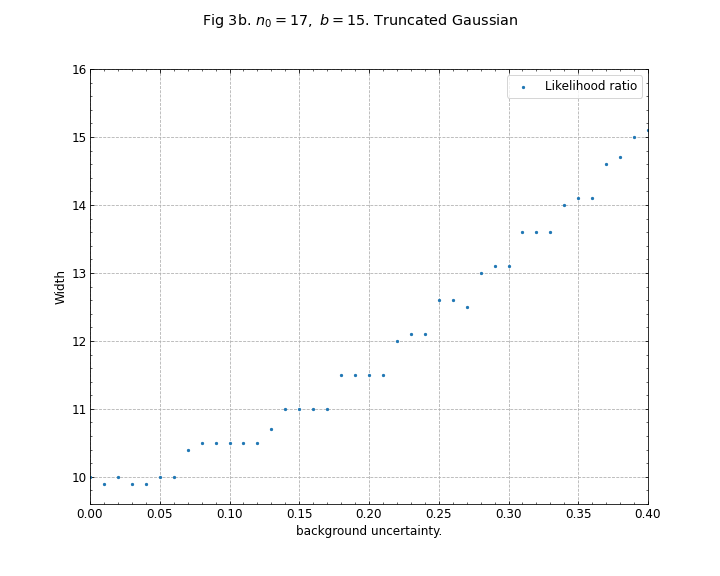

In [586]:
fig

In [575]:
# GAUSSIAN APPROX, 5e5 experiments
# rf 50
# sw 0.05
fig, ax = plt.subplots()
# ax.plot(sbgs, Delta_Phis, label='Likelihood ratio')
ax.scatter(sbgs, Delta_Phis, s=5, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Width')
ax.set_xlim([0, 0.4])
ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


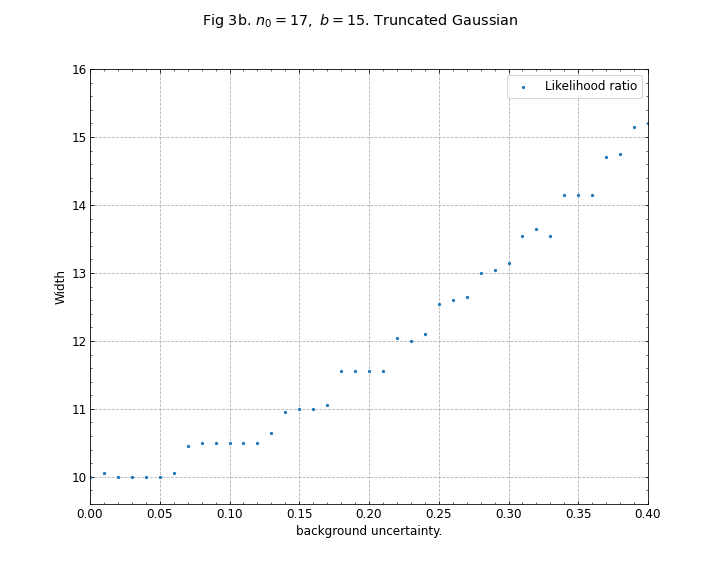

In [576]:
fig

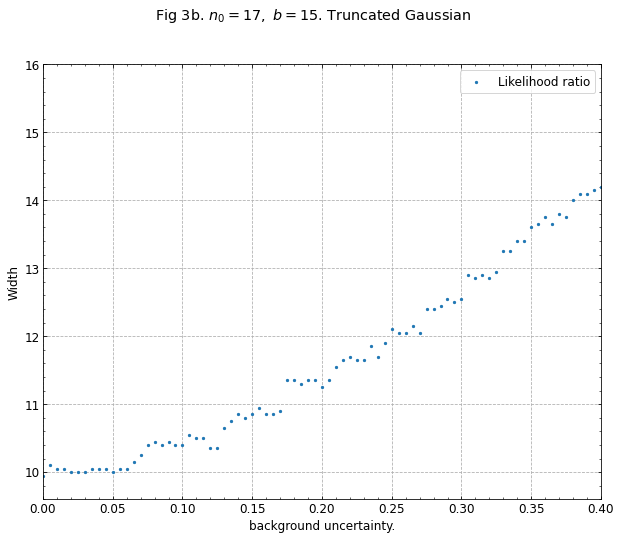

In [457]:
# GAUSSIAN APPROX, lognorm
# rf 50
# sw 0.05
fig, ax = plt.subplots()
#ax.plot(sbgs, Delta_Phis, label='Likelihood ratio')
ax.scatter(sbgs, Delta_Phis, s=5, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Width')
ax.set_xlim([0, 0.4])
ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

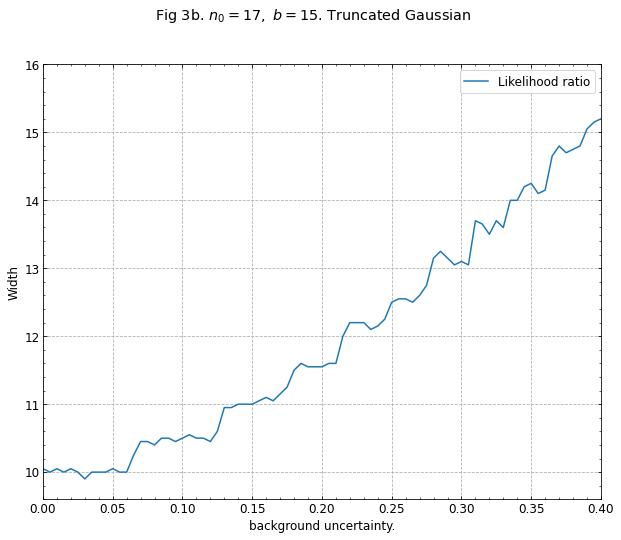

In [379]:
# GAUSSIAN APPROX
# rf 50
# sw 0.05
fig, ax = plt.subplots()
ax.plot(sbgs, Delta_Phis, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Width')
ax.set_xlim([0, 0.4])
ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

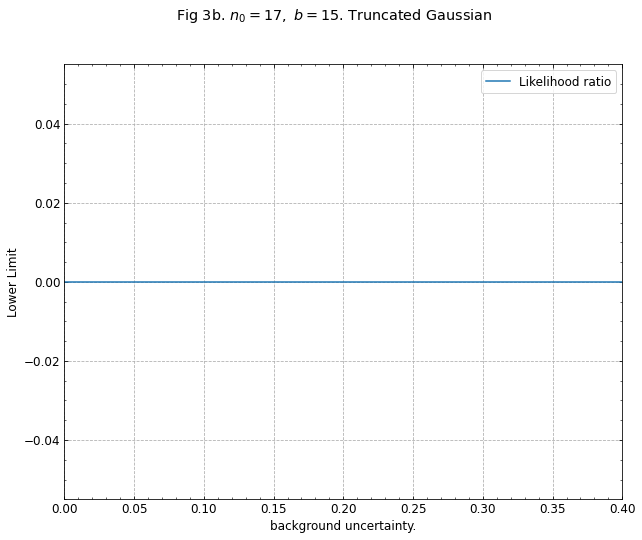

In [388]:
# GAUSSIAN APPROX
# rf 50
# sw 0.05
fig, ax = plt.subplots()
ax.plot(sbgs, Philows, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Lower Limit')
ax.set_xlim([0, 0.4])
# ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

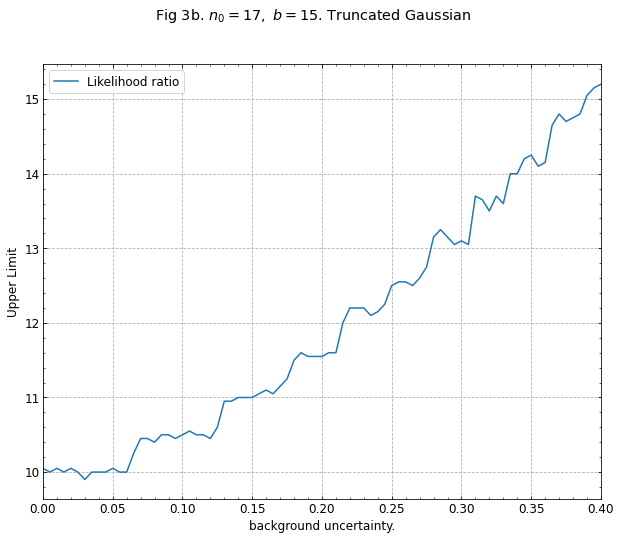

In [389]:
# GAUSSIAN APPROX
# rf 50
# sw 0.05
fig, ax = plt.subplots()
ax.plot(sbgs, Phihighs, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Upper Limit')
ax.set_xlim([0, 0.4])
# ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

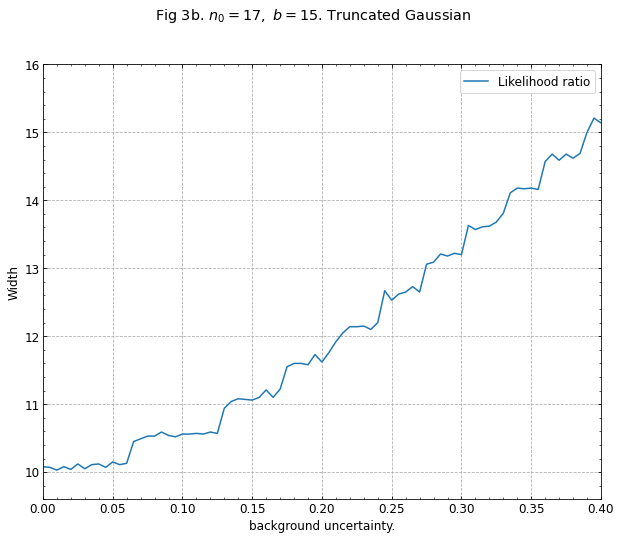

In [368]:
# rf 100
# sw 0.01
fig, ax = plt.subplots()
ax.plot(sbgs, Delta_Phis, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Width')
ax.set_xlim([0, 0.4])
ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

In [365]:
'''
# LONG RUNTIME (OVERNIGHT)
Philows = []
Phihighs = []

sbgs = np.linspace(0, 0.4, 81)

for sbg in sbgs:
    _ = main(ini_file='data/fig3b.ini', N_exp=N_exp, sbg_override=sbg)
    mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = _
    Philows.append(Philow)
    Phihighs.append(Phihigh)
    
Philows = np.array(Philows)
Phihighs = np.array(Phihighs)
Delta_Phis = Phihighs - Philows
'''
_ = None
#

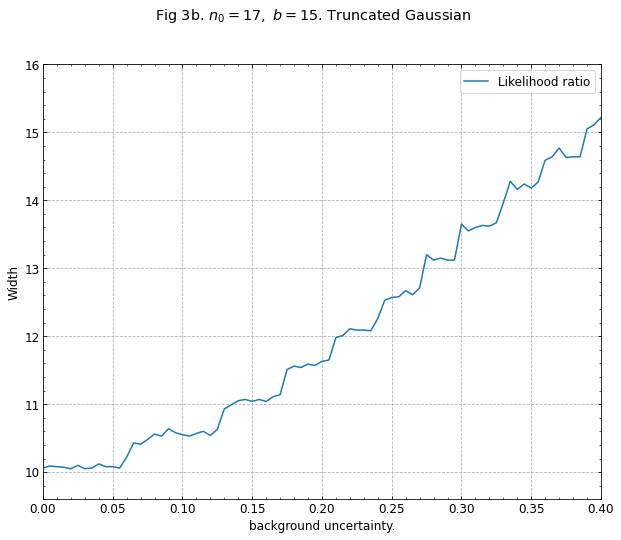

In [366]:
# rf 50
# sw 0.01
fig, ax = plt.subplots()
ax.plot(sbgs, Delta_Phis, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Width')
ax.set_xlim([0, 0.4])
ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

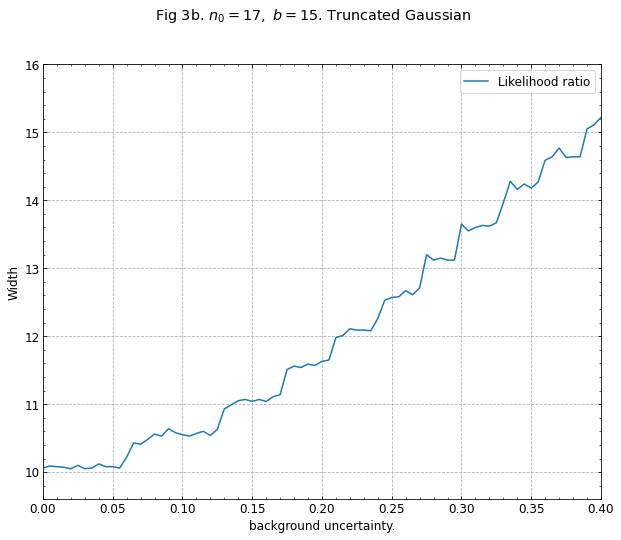

In [366]:
fig, ax = plt.subplots()
ax.plot(sbgs, Delta_Phis, label='Likelihood ratio')

ax.set_xlabel('background uncertainty.')
ax.set_ylabel('Width')
ax.set_xlim([0, 0.4])
ax.set_ylim([9.6, 16])
# add title
fig.suptitle(r'Fig 3b. $n_0 = 17,\ b=15$. Truncated Gaussian')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

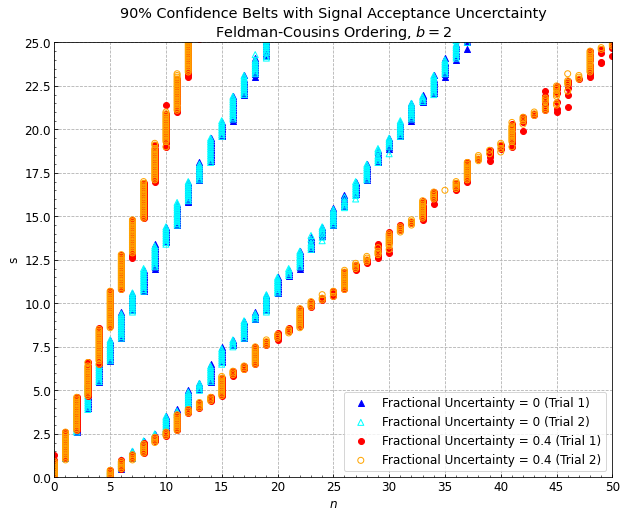

In [291]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
ax.scatter(n_limit[0,:], mus, c='blue', marker='^',
           label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(n_limit[1,:], mus, c='blue', marker='^')
ax.scatter(n_limit2[0,:], mus2, marker='^', facecolors='none', edgecolors='cyan',
           label=r'Fractional Uncertainty = 0 (Trial 2)')
ax.scatter(n_limit2[1,:], mus2, marker='^', facecolors='none', edgecolors='cyan')
ax.scatter(n_limit_[0,:], mus_, c='red',
           label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(n_limit_[1,:], mus_, c='red')
ax.scatter(n_limit_2[0,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange',
           label=r'Fractional Uncertainty = 0.4 (Trial 2)')
ax.scatter(n_limit_2[1,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,50])
ax.set_ylim([0,25])
ax.set_xticks(np.arange(0, 55, 5))
ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel('s');
ax.set_title('90% Confidence Belts with Signal Acceptance Uncerctainty\n'+r'Feldman-Cousins Ordering, $b = 2$')
ax.legend()
fig.savefig('fig2_recreate.png', transparent=False)
fig.savefig('fig2_recreate.pdf', transparent=False)

# Recreate Figure 7
- Confidence Interval width vs. background uncertainty.

In [462]:
from scipy.stats import norm

In [466]:
norm.cdf(0, loc=1, scale=0.4)

0.006209665325776132

In [470]:
norm.cdf(0, loc=4, scale=4)

0.15865525393145707

In [471]:
norm.cdf(0, loc=1, scale=1)

0.15865525393145707

In [472]:
norm.ppf(0.2, loc=1, scale=0.4)

0.6633515065708343

In [474]:
######################

In [475]:
N_exp = int(1e5)
# N_exp = int(5e5)

In [477]:
np.array([0.1, 0.2, 0.3, 0.35, 0.4])

array([0.1 , 0.2 , 0.3 , 0.35, 0.4 ])

In [409]:
_ = main(ini_file='data/fig7_gaus.ini', N_exp=N_exp, sac_override=0.1)
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = _

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.050
Feldman Cousins    1
fluxfactor:        1.000
Read from file: fig3b.in
Write to file: test.out
Exp. BG events     6.000
Measured events    17
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 1
max flux:          50.000
Number of steps: 1000
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [6.]
number of observed (y): [17]
-
Performing Construction for n0/bg: 17/6.0
-
-

.
.
.
.
.
.
.
.

Neyman Upper Limit: 17.600000000000115
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 19.00000
 FC lower limit: 5.00000


Calculation complete!


In [483]:
def single_run_sac(sac, param, N_exp):
    _ = main(ini_file=f'data/fig7_{param}.ini', N_exp=N_exp, sbg_override=sbg)
    mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = _
    return Philow, Phihigh

# def single_run_all(sbg, N_exp):
#     _ = main(ini_file='data/fig3b.ini', N_exp=N_exp, sbg_override=sbg)
#     mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = _
#     return Philow, Phihigh, 

In [377]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import multiprocessing

In [488]:
N_exp = int(1e5)
# N_exp = int(5e5)

# sacs = np.array([0.1, 0.2, 0.3, 0.35, 0.4])
sacs = np.array([0.1, 0.3, 0.4])

# params = ['gaus', 'logn']

# testing
# N_exp = int(1e3)
# sbgs = np.linspace(0, 0.4, 9)

print('Calculating CI with varying sig. eff. uncertainty')
# get CPU information
num_cpu = multiprocessing.cpu_count()
# parallel for loop
temp_gaus = (Parallel(n_jobs=num_cpu)(delayed(single_run_sac)(sac, 'gaus', N_exp) for sac in tqdm(sacs, desc='Gauss: sac #')))
temp_logn = (Parallel(n_jobs=num_cpu)(delayed(single_run_sac)(sac, 'logn', N_exp) for sac in tqdm(sacs, desc='LogN: sac #')))
# split output
Philows_g = np.array([i[0] for i in temp_gaus])
Phihighs_g = np.array([i[1] for i in temp_gaus])
Philows_l = np.array([i[0] for i in temp_logn])
Phihighs_l = np.array([i[1] for i in temp_logn])
Delta_Phis_g = Phihighs_g - Philows_g
Delta_Phis_l = Phihighs_l - Philows_l

Calculating CI with varying sig. eff. uncertainty


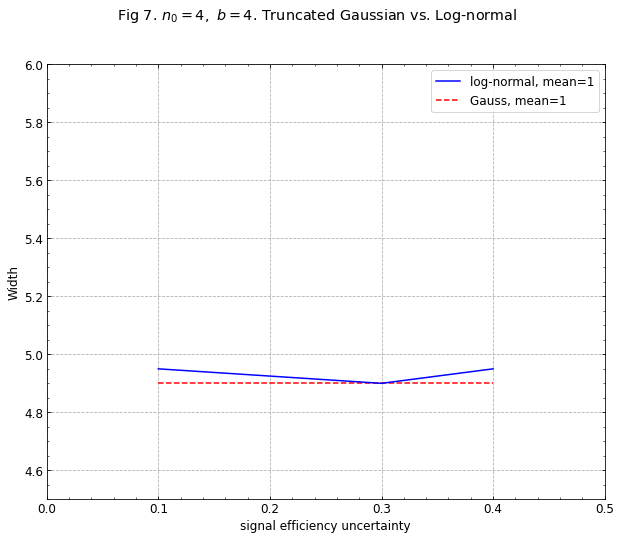

In [489]:
# rf 50
# sw 0.05
fig, ax = plt.subplots()
ax.plot(sacs, Delta_Phis_l, 'b-', label='log-normal, mean=1', zorder=99)
ax.plot(sacs, Delta_Phis_g, 'r--', label='Gauss, mean=1', zorder=98)
#ax.scatter(sbgs, Delta_Phis, s=5, label='Likelihood ratio')

ax.set_xlabel('signal efficiency uncertainty')
ax.set_ylabel('Width')
ax.set_xlim([0, 0.5])
ax.set_ylim([4.5, 6])
# add title
fig.suptitle(r'Fig 7. $n_0 = 4,\ b=4$. Truncated Gaussian vs. Log-normal')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

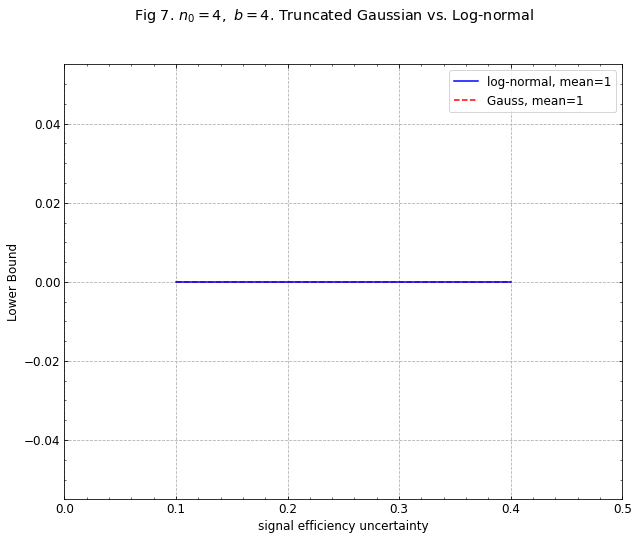

In [486]:
# rf 50
# sw 0.05
fig, ax = plt.subplots()
ax.plot(sacs, Philows_l, 'b-', label='log-normal, mean=1', zorder=99)
ax.plot(sacs, Philows_g, 'r--', label='Gauss, mean=1', zorder=98)
#ax.scatter(sbgs, Delta_Phis, s=5, label='Likelihood ratio')

ax.set_xlabel('signal efficiency uncertainty')
ax.set_ylabel('Lower Bound')
ax.set_xlim([0, 0.5])
# ax.set_ylim([4.5, 6])
# add title
fig.suptitle(r'Fig 7. $n_0 = 4,\ b=4$. Truncated Gaussian vs. Log-normal')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

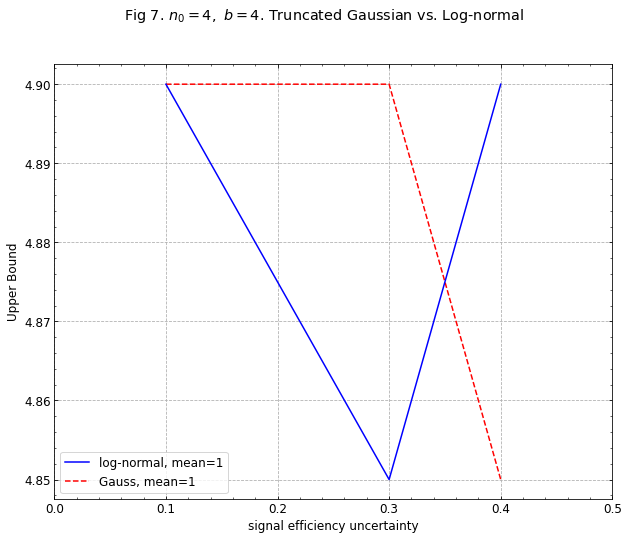

In [487]:
# rf 50
# sw 0.05
fig, ax = plt.subplots()
ax.plot(sacs, Phihighs_l, 'b-', label='log-normal, mean=1', zorder=99)
ax.plot(sacs, Phihighs_g, 'r--', label='Gauss, mean=1', zorder=98)
#ax.scatter(sbgs, Delta_Phis, s=5, label='Likelihood ratio')

ax.set_xlabel('signal efficiency uncertainty')
ax.set_ylabel('Upper Bound')
ax.set_xlim([0, 0.5])
# ax.set_ylim([4.5, 6])
# add title
fig.suptitle(r'Fig 7. $n_0 = 4,\ b=4$. Truncated Gaussian vs. Log-normal')
# minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax.tick_params(which='both', direction='in', top=True, right=True, bottom=True)
ax.legend();

# Make Plot for Mu2e SU2020

## SU2020 Background Numbers

In [292]:
NPOT = 3.77e19
scaleLuminosity_ = 1.
dio_bkg = 0.0096  #see docdb-36476 Table 9                                                                                                          
dio_frac_unc = 0.834  #using systematic upper estimate with statistical error                                                                       
rpc_bkg = 7.06e-4  #see docdb-36503 section 11.2                                                                                                    
rpc_frac_unc = 0.16  #using systematic upper estimate with statistical error                                                                        
extinction = 1.  #in units of 10^-10, FIXME: Get expected value                                                                                     
rpc_oot_bkg = 13.9e-4*extinction  #see docdb-36503 section 11.3                                                                                     
rpc_oot_frac_unc = 0.12  #using systematic upper estimate with statistical error                                                                    
pbar_bkg = 0.069 * NPOT/3.6e20  #see docdb-36494 eq 60                                                                                           
pbar_frac_unc = 1.  #100% uncertainty quoted - careful with Gaussian mode!                                                                          
cr_lo_bkg = 0.03  #see docdb-38052 slide 20                                                                                                         
cr_lo_frac_unc = 0.20                                                                                                                                
cr_hi_bkg = 0.02  #see docdb-38052 slide 20                                                                                                         
cr_hi_frac_unc = 0.50                                                                                                                                
lumi_frac_unc = 0.1                                                                                                                                  
signal_acceptance = 0.1114  #see docdb-36491 Table 5                                                                                                
sig_frac_unc = 0.0715  #taken as the average of the momentum scale, but should be two-sided and correlated with DIO                                 
#ses = 1./(scaleLuminosity_*3.77e19*1.59e-3*0.609)  #for signal strength -> R_mue
ses = (NPOT*1.88e-3* .609 * signal_acceptance)**(-1)
# ses = (N_POT * P_mu_stop * f_capture * signal_acceptance) # see docdb-36491 Table 5 for numbers

In [293]:
3.8e20 

3.8e+20

In [294]:
3.6e20 * signal_acceptance

4.0104e+19

In [295]:
3.6e20 * 0.0903

3.2508e+19

In [296]:
ses

2.0796886280602864e-16

In [297]:
ses

2.0796886280602864e-16

### Backgrounds

In [298]:
bgs = np.array([dio_bkg, rpc_bkg, rpc_oot_bkg, pbar_bkg, cr_lo_bkg, cr_hi_bkg])
frac_uncs = np.array([dio_frac_unc, rpc_frac_unc, rpc_oot_frac_unc, pbar_frac_unc, cr_lo_frac_unc, cr_hi_frac_unc])

In [299]:
bgs, frac_uncs

(array([0.0096    , 0.000706  , 0.00139   , 0.00722583, 0.03      ,
        0.02      ]),
 array([0.834, 0.16 , 0.12 , 1.   , 0.2  , 0.5  ]))

In [300]:
total_bg = np.sum(bgs)
total_bg

0.06892183333333333

In [301]:
uncs = frac_uncs * bgs
uncs

array([0.0080064 , 0.00011296, 0.0001668 , 0.00722583, 0.006     ,
       0.01      ])

In [302]:
total_bg_unc = np.linalg.norm(uncs)
total_bg_unc

0.01588570711434373

In [303]:
total_bg_frac_unc = total_bg_unc / total_bg
total_bg_frac_unc

0.23048874857280927

In [304]:
np.sum(np.square(uncs))**(1/2)

0.01588570711434373

### Signal Efficiency

In [305]:
signal_acceptance

0.1114

In [306]:
sig_frac_unc

0.0715

## Run with the different input files

In [307]:
N_exp = int(1e5)

In [308]:
# no signal uncertainty
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/su2020_no_sys.ini',
                                                                     N_exp=N_exp)
mus2, Philow2, Phihigh2, n_limit2, matrix2, fluxarray2, nent2, steps2 = main(ini_file='data/su2020_no_sys.ini',
                                                                             N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          100.000
Number of steps: 1000
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [0.06892183]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.2000000000000006
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.30000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.900

In [309]:
# signal uncertainty
mus_, Philow_, Phihigh_, n_limit_, matrix_, fluxarray_, nent_, steps_ = main(ini_file='data/su2020_sys.ini',
                                                                     N_exp=N_exp)
mus_2, Philow_2, Phihigh_2, n_limit_2, matrix_2, fluxarray_2, nent_2, steps_2 = main(ini_file='data/su2020_sys.ini',
                                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.100
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.071
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.230
Parametrization: 3
max flux:          100.000
Number of steps: 1000
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [0.06892183]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.2000000000000006
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.40000
 FC lower limit: 0.00000


Calculation complete!
Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.900

In [310]:
#mus, n_limit

In [311]:
mus.shape, n_limit.shape

((1000,), (2, 1000))

In [312]:
b = 0.06892183

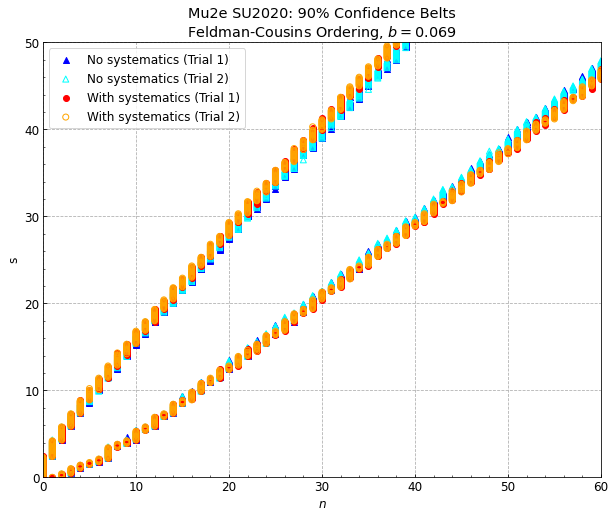

In [313]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
ax.scatter(n_limit[0,:], mus, c='blue', marker='^',
           label='No systematics (Trial 1)')
           #label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(n_limit[1,:], mus, c='blue', marker='^')
ax.scatter(n_limit2[0,:], mus2, marker='^', facecolors='none', edgecolors='cyan',
           label='No systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0 (Trial 2)')
ax.scatter(n_limit2[1,:], mus2, marker='^', facecolors='none', edgecolors='cyan')
ax.scatter(n_limit_[0,:], mus_, c='red',
           label='With systematics (Trial 1)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(n_limit_[1,:], mus_, c='red')
ax.scatter(n_limit_2[0,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange',
           label='With systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 2)')
ax.scatter(n_limit_2[1,:], mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,60])
ax.set_ylim([0,50])
#ax.set_xticks(np.arange(0, 55, 5))
# ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel('s');
ax.set_title('Mu2e SU2020: 90% Confidence Belts\n'+rf'Feldman-Cousins Ordering, $b = {total_bg:0.3f}$')
ax.legend()
fig.savefig('su2020_CI.png', transparent=False)
fig.savefig('su2020_CI.pdf', transparent=False)

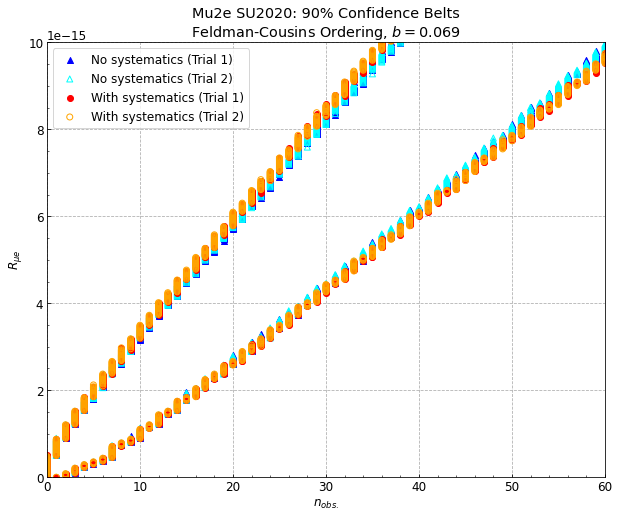

In [314]:
#fig, ax = plt.subplots(figsize=(10,8))
fig, ax = plt.subplots()
ax.scatter(n_limit[0,:], ses*mus, c='blue', marker='^',
           label='No systematics (Trial 1)')
           #label=r'Fractional Uncertainty = 0 (Trial 1)')
ax.scatter(n_limit[1,:],  ses*mus, c='blue', marker='^')
ax.scatter(n_limit2[0,:],  ses*mus2, marker='^', facecolors='none', edgecolors='cyan',
           label='No systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0 (Trial 2)')
ax.scatter(n_limit2[1,:],  ses*mus2, marker='^', facecolors='none', edgecolors='cyan')
ax.scatter(n_limit_[0,:],  ses*mus_, c='red',
           label='With systematics (Trial 1)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 1)')
ax.scatter(n_limit_[1,:],  ses*mus_, c='red')
ax.scatter(n_limit_2[0,:],  ses*mus_2, marker='o', facecolors='none', edgecolors=f'orange',
           label='With systematics (Trial 2)')
#            label=r'Fractional Uncertainty = 0.4 (Trial 2)')
ax.scatter(n_limit_2[1,:],  ses*mus_2, marker='o', facecolors='none', edgecolors=f'orange')
ax.set_xlim([0,60])
ax.set_ylim([0,1e-14])
#ax.set_xticks(np.arange(0, 55, 5))
# ax.set_yticks(np.arange(0, 27.5, 2.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(direction='in', which='both')
ax.set_xlabel(r'$n_{obs.}$')
# ax.set_ylabel(r'$\mu$');
ax.set_ylabel(r'$R_{\mu e}$');
ax.set_title('Mu2e SU2020: 90% Confidence Belts\n'+rf'Feldman-Cousins Ordering, $b = {total_bg:0.3f}$')
ax.legend()
fig.savefig('su2020_CI_ses.png', transparent=False)
fig.savefig('su2020_CI_ses.pdf', transparent=False)

In [315]:
ses

2.0796886280602864e-16

# Calculate Limits for some interesting cases of $n_{obs}$
**CAUTION: These take a long time to run.**
- Width = 0.01

In [242]:
N_exp = int(1e5)

In [254]:
# no signal uncertainty
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/su2020_no_sys_n_calcs.ini',
                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.010
Feldman Cousins    1
fluxfactor:        1.000
Read from file: su2020.in
Write to file: su2020_no_sys.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          50.000
Number of steps: 5000
CAUTION: not bigger than 1000!
-
-
Mode: Read input from file
-
expected background (x): [0.06892183 0.06892183 0.06892183 0.06892183 0.06892183 0.06892183
 0.06892183]
number of observed (y): [ 0.  1.  2.  4.  8. 16. 32.]
-
Performing Construction for n0/bg: 0.0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.209999999999997
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.37000
 FC lower limit: 0.00000


-
Performing Constru

In [255]:
# signal uncertainty
mus_, Philow_, Phihigh_, n_limit_, matrix_, fluxarray_, nent_, steps_ = main(ini_file='data/su2020_sys_n_calcs.ini',
                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.010
Feldman Cousins    1
fluxfactor:        1.000
Read from file: su2020.in
Write to file: su2020_sys.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.071
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.230
Parametrization: 3
max flux:          50.000
Number of steps: 5000
CAUTION: not bigger than 1000!
-
-
Mode: Read input from file
-
expected background (x): [0.06892183 0.06892183 0.06892183 0.06892183 0.06892183 0.06892183
 0.06892183]
number of observed (y): [ 0.  1.  2.  4.  8. 16. 32.]
-
Performing Construction for n0/bg: 0.0/0.06892183333333333
-
-

.

Neyman Upper Limit: 2.249999999999996
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.40000
 FC lower limit: 0.00000


-
Performing Constructi

In [256]:
ses

2.0796886280602864e-16

# Compare with M. MacKenzie
- Code in C++/ROOT

In [212]:
N_exp = int(1e5)

In [216]:
mus, Philow, Phihigh, n_limit, matrix, fluxarray, nent, steps = main(ini_file='data/su2020_no_sys_mmackenz.ini',
                                                                     N_exp=N_exp)

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.025
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     0.069
Measured events    0
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.000
Parametrization: 3
max flux:          20.000
Number of steps: 800
CAUTION: not bigger than 1000!
-
-
Mode: single construction
-
expected background (x): [0.0689218]
number of observed (y): [0]
-
Performing Construction for n0/bg: 0/0.0689218
-
-

.
.
.

Neyman Upper Limit: 2.199999999999996
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.37500
 FC lower limit: 0.00000


Calculation complete!


In [214]:
2.2*ses

4.575314981732631e-16

In [217]:
(2.375+2.400)/2

2.3875

# Profiling Code

In [38]:
%prun main()

Performing Conf Belt Const :
Output hbfile:     test.hb
fill diagnostic histos 0
Confidence Level 0.90000
Condition (1=yes) 0
stepwidth : 0.010
Feldman Cousins    1
fluxfactor:        1.000
Read from file: test.in
Write to file: test.out
Exp. BG events     3.000
Measured events    7
 
Used Paramterisation :
Gaussian = 1
flat = 2
log-normal = 3
 
rel Aeff unc (sig): 0.000
Parametrization: 3
rel Aeff unc (bck): 0.000
Parametrization: 1
rel bg unc:        0.109
Parametrization: 3
max flux:          5.000
Number of steps: 500
CAUTION: not bigger than 1000!
-
-
Mode: Read input from file
-
expected background (x): [0.041]
number of observed (y): [0.]
-
Performing Construction for n0/bg: 0.0/0.041
-
-

.
.
.
.
.
.
.
.
.
.

Neyman Upper Limit: 2.259999999999996
.
.
.
.
.
.
.
.
.
.

exiting flux loop
 FC upper limit: 2.41000
 FC lower limit: 0.00000


Calculation complete!
 

In [ ]:
#ses = 5.56e-17
#ses * 2.2, ses*

- Currently runs quite a bit slower than FORTRAN
- Vectorize and should run quicker.
- Could also try using Gaussian approx for mu>20 (Poisson)

# SCRATCH

## Log Normal vs. Gaussian

In [79]:
N = 100000
mu = 1
std = 0.4
var = std**2

In [80]:
# generate gaussian and look at sample mean / std
xs = np.random.normal(loc=mu, scale=std, size=N)

In [81]:
xs.mean(), xs.std()

(1.001047438157665, 0.39941000718227043)

In [82]:
std_ln = std
mu_ln = np.log(mu) - std**2 / 2

In [84]:
std_ln, mu_ln

(0.4, -0.08000000000000002)

In [87]:
# generate log-normal
ys = np.random.lognormal(mean=mu_ln, sigma=std_ln, size=N)

In [88]:
ys.mean(), ys.std()

(0.9982725656238518, 0.41613017191659896)

- These look pretty close! Let's try the wiki method, which should get both spot on

In [93]:
mu_ln = np.log(mu**2 / (mu**2 + std**2)**(1/2))
std_ln = (np.log(1+std**2/mu**2))**(1/2)

In [94]:
mu_ln, std_ln

(-0.07421000255913678, 0.38525317015992666)

In [95]:
# generate log-normal
ys = np.random.lognormal(mean=mu_ln, sigma=std_ln, size=N)

In [96]:
ys.mean(), ys.std()

(0.9986280186915583, 0.3984484719297211)

- Looks about the same as Conrad result.

**Prescription**
- $\mu, \sigma$ for a nuisance parameter given (expected background, signal efficiency, background efficiency)
- If log-normal parameterization selected (3), then:
    - $\mu_{LN} = \ln{\mu} - \sigma^2 / 2$
    - $\sigma_{LN} = \sigma$
    - These are the parameters to use with the log-normal generator